In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install tensorflow matplotlib scikit-learn

In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

In [11]:
import os

base_dir = '/content/hemato_dataset'

classes = ['eosinophil', 'lymphocyte', 'monocyte', 'neutrophil']
splits = ['train', 'val', 'test']

In [14]:
for split in splits:
    for cls in classes:
        os.makedirs(os.path.join(base_dir, split, cls), exist_ok=True)

In [15]:
from google.colab import files
uploaded = files.upload()

Saving raw.zip to raw.zip


In [18]:
import zipfile

with zipfile.ZipFile('/content/raw.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/unzipped')

In [19]:
!ls /content/unzipped

raw


In [20]:
!pip install split-folders

import splitfolders

splitfolders.ratio('/content/unzipped', output=base_dir, seed=42, ratio=(.7, .15, .15))

Copying files: 364 files [00:00, 4812.00 files/s]


In [22]:
train_path = '/content/hemato_dataset/train'
val_path = '/content/hemato_dataset/val'
test_path = '/content/hemato_dataset/test'

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(train_path, target_size=(224, 224), batch_size=32, class_mode='categorical')
val_gen = val_datagen.flow_from_directory(val_path, target_size=(224, 224), batch_size=32, class_mode='categorical')
test_gen = test_datagen.flow_from_directory(test_path, target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False)

Found 254 images belonging to 5 classes.
Found 54 images belonging to 5 classes.
Found 784 images belonging to 5 classes.


In [24]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(5, activation='softmax')(x)  # Changed to 5 neurons

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,629 (90.98 MB)

 Trainable params: 262,917 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [25]:
history = model.fit(train_gen, validation_data=val_gen, epochs=10)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6594 - loss: 0.8647

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 71s 8s/step - accuracy: 0.6833 - loss: 0.8125 - val_accuracy: 1.0000 - val_loss: 0.0039
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 59s 7s/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 1.0000 - val_loss: 2.5931e-04
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 63s 8s/step - accuracy: 1.0000 - loss: 1.8820e-04 - val_accuracy: 1.0000 - val_loss: 7.1605e-05
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 62s 8s/step - accuracy: 1.0000 - loss: 6.0078e-05 - val_accuracy: 1.0000 - val_loss: 3.8162e-05
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 59s 7s/step - accuracy: 1.0000 - loss: 3.4733e-05 - val_accuracy: 1.0000 - val_loss: 2.8091e-05
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 58s 7s/step - accuracy: 1.0000 - loss: 2.6626e-05 - val_accuracy: 1.0000 - val_loss: 2.4217e-05
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 59s 8s/step - accuracy: 1.0000 - loss: 2.3547e-05 - val_accuracy: 1.0000 - val_loss: 2.2499e-05
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 58s 8s/step - accuracy: 1.0000 - loss: 2.1992e-05 - val_accurac

In [26]:
predictions = model.predict(test_gen)
y_pred = np.argmax(predictions, axis=1)
y_true = test_gen.classes

print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 165s 6s/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       728
           4       0.07      1.00      0.13        56

    accuracy                           0.07       784
   macro avg       0.04      0.50      0.07       784
weighted avg       0.01      0.07      0.01       784

[[  0 728]
 [  0  56]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


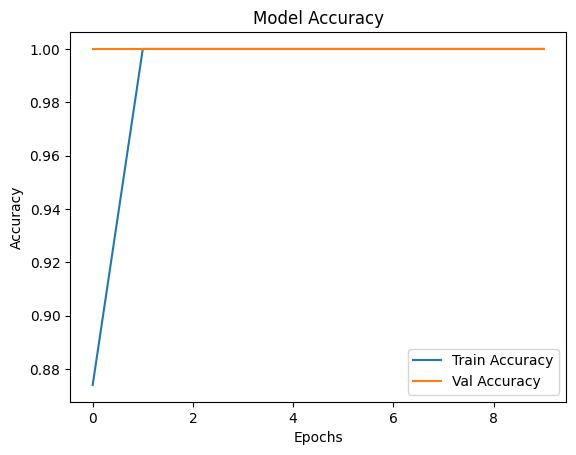

In [27]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()